## Exploring PACE OCI vegetation indexes
In this tutorial, we will work with Land data product suite from the PACE Ocean Color Instrument (OCI) to explore variations in hyperspectral vegetation indexes trhough time. Specifically, we’ll recreate and investigate the RGB composite map shown below, where three pigment-sensitive vegetation indices are mapped to color channels:

- Red: Modified Anthocyanin Reflectance Index (mARI)
- Green: Chlorophyll Index Red Edge (CIRE)
- Blue: Carotenoid Content Index (Car)


<figure>
    <img src="img/pace_global.PNG" alt="" width="500">
    <figcaption style="font-style: italic; margin-bottom: 40px;"> </figcaption>
</figure> 

#### Hyperspectral vegetation indexes 
The PACE OCI instrument is the first to provide global, high-temporal-resolution hyperspectral data over land. This capability enables time series of vegetation indices that go beyond traditional broadband metrics like NDVI and EVI, allowing us to target specific plant pigments such as anthocyanins, chlorophyll, and carotenoids.

Since such dense spectral data have never been available at this spatial and temporal scale, we now have a unique opportunity to assess the global applicability of hyperspectral vegetation indices and improve our understanding of the conditions, limitations, and caveats that affect where and when they should be used. 

The three indexes we will use in this tutorial are:

---

##### 1. Modified Anthocyanin Reflectance Index (mARI)

$$
\text{mARI} = \left( \frac{1}{\rho_{550}} - \frac{1}{\rho_{705}} \right) \cdot \rho_{800}
$$

---

##### 2. Chlorophyll Index Red Edge (CIRE)

$$
\text{CIRE} = \left( \frac{\rho_{800}}{\rho_{705}} \right) - 1
$$

---

##### 3. Carotenoid Content Index (Car)

$$
\text{Car} = \left( \frac{1}{\rho_{495}} - \frac{1}{\rho_{705}} \right) \cdot \rho_{800}
$$



#### Australia Case Study

In the visualization above, the central desert regions of Australia appear magenta, indicating high values of both mARI (red) and Car (blue), despite being sparsely vegetated area. This raises important questions about what these indices are capturing in arid environments and how they should be used in a global context.

---

#### Objectives

This notebook will:

1. Demonstrate two useful visualization techniques for PACE land data:
   - An RGB animation of three vegetation indices over time.
   - An interactive viewer that lets users click on the map to explore temporal dynamics of a selected vegetation index.
2. Investigate the regions of Australia for spectral signals contributing to the magenta display. 



### Set up 

In [1]:
# import packages 
import earthaccess
import xarray as xr
import hvplot.xarray
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math
import pandas as pd
import holoviews as hv

### 1. Query land data products

We will use `earthaccess` to find the PACE vegetation index monthly composite products over Australia between March 2024 and March 2025. The shortname for these products is `PACE_OCI_L3M_LANDVI`.

In [2]:
# authenticate earth access
auth = earthaccess.login(persist=True)

In [3]:
# select time span and study area
tspan = ("2024-03-01", "2025-03-31")
bbox = (113.338953078, -43.6345972634, 153.569469029, -10.6681857235)

In [4]:
results_land = earthaccess.search_data(
    short_name="PACE_OCI_L3M_LANDVI",
    temporal=tspan,
    bounding_box=bbox,
    granule_name="*.MO.*0p1deg*",  # Daily, 8-day or monthly: Day, 8D or MO | Resolution: 0p1deg or 0.4km
)

We will use the `earthaccess.open` function to stream the vegetation index products returned by our query, allowing us to read the data directly without downloading the full files.

In [5]:
paths = earthaccess.open(results_land)
#paths

QUEUEING TASKS | :   0%|          | 0/13 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/13 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/13 [00:00<?, ?it/s]

Now we open the files for all dates using `xarray.Dataset` and we will concatenate the data by date. This will allow us to plot information for several dates at once.  

In [6]:
dataset_land = xr.open_mfdataset(paths,
    combine="nested",
    concat_dim="date" )


### 2. Create animation of false color display

We will change the range of values for the three vegetation indexes to the ones used in the intial display. These ranges were manually selected to optimize the display and highlight meaningful patterns in the data.

In [7]:
dataset_land["mari"] = dataset_land["mari"].clip(
    min=1.3,
    max=2.0
)
dataset_land["cire"] = dataset_land["cire"].clip(
    min=0.5,
    max=2.0
)
dataset_land["car"] = dataset_land["car"].clip(
    min=1.3,
    max=6.2
)

In [8]:
# the land products come with a whole suite of vegetation indices 
# we will remove the ones we no longer need
dataset_veg = dataset_land.drop_vars(
    ["palette", "ndvi", "evi", "ndwi", "ndii", "cci", "ndsi", "pri"]
)

In [9]:
# normalize our dataset
dataset_v_norm = dataset_veg.astype(np.float64)
dataset_v_norm = (
    (dataset_veg - dataset_veg.min())
    / (dataset_veg.max() - dataset_veg.min())
)

data_land = dataset_v_norm.to_dataarray()
dataset_v_norm.to_dataarray()

<xarray.DataArray (variable: 3, date: 13, lat: 1800, lon: 3600)> Size: 1GB
dask.array<stack, shape=(3, 13, 1800, 3600), dtype=float32, chunksize=(1, 1, 512, 1024), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 7kB 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * lon       (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
  * variable  (variable) object 24B 'cire' 'car' 'mari'
Dimensions without coordinates: date

Now we will select the three vegetation indexes that are in the original image 

In [10]:
plant_pigments = data_land.sel(
variable = ['mari',  'cire', 'car']
)

#### Clip to Australia
Although we queried the earth access with the australia bounding box, our images are not cropped to that area because the L3 products are global. Here, will clip the products to the bounding box of australia.

In [11]:
min_lon, max_lat, max_lon, min_lat = bbox
australia = plant_pigments.sel(lat=slice(min_lat, max_lat), lon=slice(min_lon, max_lon))

Next we will create a few functions to generate an animation of this data.

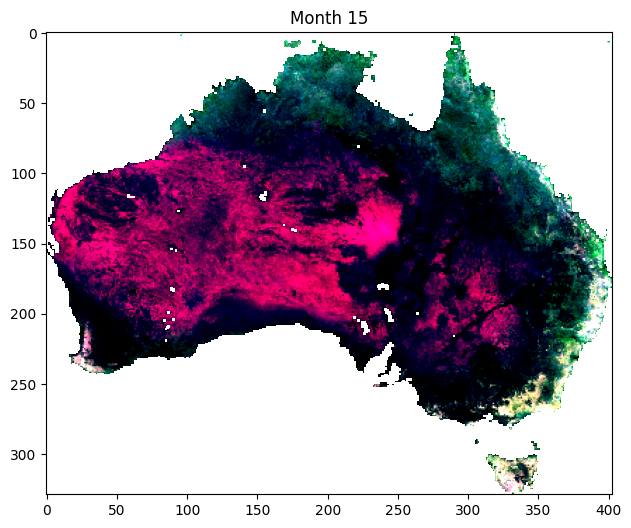

In [12]:
num_channels, num_dates, lat_dim, lon_dim = australia.shape

assert num_channels == 3, "Expected 3 variables for RGB"

# Normalize data to [0, 1] for imshow (if needed)
def normalize_rgb(rgb_array):
    """Normalize to [0, 1] per channel if values are not already in that range"""
    rgb_norm = np.empty_like(rgb_array, dtype=np.float32)
    for c in range(3):
        channel = rgb_array[c]
        min_val = np.nanmin(channel)
        max_val = np.nanmax(channel)
        rgb_norm[c] = (channel - min_val) / (max_val - min_val + 1e-8)
    return rgb_norm

# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Get first frame RGB image
rgb0 = normalize_rgb(australia[:, 0, :, :])
rgb0 = np.moveaxis(rgb0, 0, -1)  # (3, H, W) → (H, W, 3)

im = ax.imshow(rgb0, animated=True)
title = ax.set_title("Month 3")

# Animation update function
def update(frame):
    rgb = normalize_rgb(australia[:, frame, :, :])
    rgb = np.moveaxis(rgb, 0, -1)  # (3, H, W) → (H, W, 3)
    im.set_data(rgb)
    title.set_text(f"Month {frame + 3}")
    return [im, title]

ani = animation.FuncAnimation(fig, update, frames=num_dates, blit=True, interval=500)
# save the animation 
ani.save('australia_plant_pigment_animation.gif', writer='pillow', fps=2)

plt.show()

### 3. Create an interactive plot to visualize index time series 

Combining spatial and veg index time series information into a single visualization can be a useful tool for exploring land patterns. Using the streams module from Holoviews we can link a spatial map to a plots of veg indexes.

In [13]:
date_values = pd.date_range(start=tspan[0], periods=dataset_v_norm.dims["date"], freq="M")
ds = dataset_v_norm.sel(lat=slice(min_lat, max_lat), lon=slice(min_lon, max_lon)).assign_coords(date=date_values)

First we create a map of our RGB dataset to create a spatial plot for us to click on. 

In [14]:
# === RGB composite map ===
mymap = australia.assign_coords(date=date_values).hvplot.rgb(
    x='lon', y='lat', bands='variable', aspect='equal',
    frame_height=350, frame_width=550, widget_location ='top'
)
mymap

Column
    [0] WidgetBox(align=('center', 'start'))
        [0] DiscreteSlider(name='date', options={'2024-03-31 00:00:00': np...}, value=np.datetime64('2024-03-31T...)
    [1] HoloViews(DynamicMap, sizing_mode='fixed', widget_location='top')

This ‘map’ will be an inputs for a function to return values from the full dataset at that latitude and longitude location selected by the user. To do so we use the Point Draw tool from the holoviews library.

Click in the RGB image to add spectra to the plot. You can also click and hold the mouse button then drag previously placed points. To remove a point click and hold the mouse button down, then press the backspace key.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
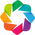

:Layout
   .DynamicMap.I   :DynamicMap   [date]
      :Overlay
         .RGB.I    :RGB   [lon,lat]   (R,G,B)
         .Points.I :Points   [x,y]   (id,color)
   .DynamicMap.II  :DynamicMap   []
      :Overlay
         .Curve.Point_0 :Curve   [date]   (mari)
   .DynamicMap.III :DynamicMap   []
      :Overlay
         .Curve.Point_0 :Curve   [date]   (car)
   .DynamicMap.IV  :DynamicMap   []
      :Overlay
         .Curve.Point_0 :Curve   [date]   (cire)

In [15]:
hv.extension('bokeh')


POINT_LIMIT = 10
color_cycle = hv.Cycle('Category20')
colors = [str(color_cycle.values[i]) for i in range(POINT_LIMIT)]  # ensure strings


xmid = ds.lon.values[int(len(ds.lon) / 2)]
ymid = ds.lat.values[int(len(ds.lat) / 2)]


clicked_points = ([xmid], [ymid], [0], [colors[0]])
points_df = pd.DataFrame({
    'x': clicked_points[0],
    'y': clicked_points[1],
    'id': clicked_points[2],
    'color': clicked_points[3]
})


points = hv.Points(points_df, vdims=['id', 'color']).opts(
    color='color', size=10, tools=['hover'], line_color='gray'
)


points_stream = hv.streams.PointDraw(
    data=points_df.to_dict(orient='list'),
    source=points,
    drag=True,
    num_objects=POINT_LIMIT
)


plant_pigments = ds.to_dataarray().sel(
variable = ['mari',  'cire', 'car']
)
mymap = plant_pigments.hvplot.rgb(
    x='lon', y='lat', bands='variable', aspect='equal',
    frame_height=350, frame_width=550
)

# Pointer streams
posxy = hv.streams.PointerXY(source=mymap, x=xmid, y=ymid)

def make_click_spectra(varname):
    def plot(data):
        coordinates = []
        if data is None or not any(len(d) for d in data.values()):
            coordinates.append((clicked_points[0][0], clicked_points[1][0]))
        else:
            coordinates = list(zip(data['x'], data['y']))

        plots = []
        for i, coords in enumerate(coordinates):
            x, y = coords
            data_sel = ds.sel(lon=x, lat=y, method="nearest")
            color_string = colors[i % len(colors)]  

            line = data_sel.hvplot.line(
                y=varname, x="date", label=f"Point {i}",line_color=color_string
            ).opts( height=300, width=650) 
            plots.append(line)

            points_stream.data["id"][i] = i
            points_stream.data["color"][i] = color_string

        return hv.Overlay(plots).opts(title=varname.capitalize())
    return plot


mari_dmap = hv.DynamicMap(make_click_spectra('mari'), streams=[points_stream])
car_dmap = hv.DynamicMap(make_click_spectra('car'), streams=[points_stream])
cire_dmap = hv.DynamicMap(make_click_spectra('cire'), streams=[points_stream])


layout = (
    (mymap.opts(
        title="RGB Composite Map",
        show_legend=True,
        fontscale=1.5
    ) * points).opts(
        hv.opts.Overlay(active_tools=['point_draw'])
    ) +
    mari_dmap +
    car_dmap +
    cire_dmap
).cols(1)

layout

<video controls src="veg_indices_animation.mp4" width="500" height="500">

Hematite primarily absorbs light at approximately 550 nm and 880 nm (associated with red color), which may be the reason of the high anthocyanin in the desert area in Australia. 

<small><em>*Heller Pearlshtien, D., & Ben‑Dor, E. (2020). Effect of organic matter content on the spectral signature of iron oxides across the VIS–NIR spectral region in artificial mixtures: An example from a red soil from Israel. Remote Sensing, 12(12), 1960. https://doi.org/10.3390/rs12121960*</small></em>

Going back to the plant pigment indices we see that mARI is highly sensitive to wavelength 550nm.

##### 1. Modified Anthocyanin Reflectance Index (mARI)

$$
\text{mARI} = \left( \frac{1}{\rho_{550}} - \frac{1}{\rho_{705}} \right) \cdot \rho_{800}
$$
